In [1]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np


In [12]:
import zipfile

# Unzip the file
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall("archive")  # Extract to 'archive' folder

print(" Archive Extracted Successfully")


 Archive Extracted Successfully


In [13]:
import os

# Check the structure inside the 'archive' folder
print("Files in 'archive' directory:")
print(os.listdir('archive'))

# Check the structure inside 'archive/train' and 'archive/test'
print("\nFiles in 'archive/train' directory:")
print(os.listdir('archive/train'))

print("\nFiles in 'archive/test' directory:")
print(os.listdir('archive/test'))


Files in 'archive' directory:
['train', 'test']

Files in 'archive/train' directory:
['neutral', 'surprise', 'disgust', 'angry', 'sad', 'happy', 'fear']

Files in 'archive/test' directory:
['neutral', 'surprise', 'disgust', 'angry', 'sad', 'happy', 'fear']


**Load the Image Data**

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions and batch size
image_size = (48, 48)
batch_size = 64

# Paths to the train and test directories
train_dir = "archive/train"
test_dir = "archive/test"

# Data augmentation for training set
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Train data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",  # Images are in grayscale
    class_mode="categorical",  # Multi-class classification
    subset="training",
    shuffle=True
)

# Validation data generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False  # No shuffle for testing
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Preview Sample Images**

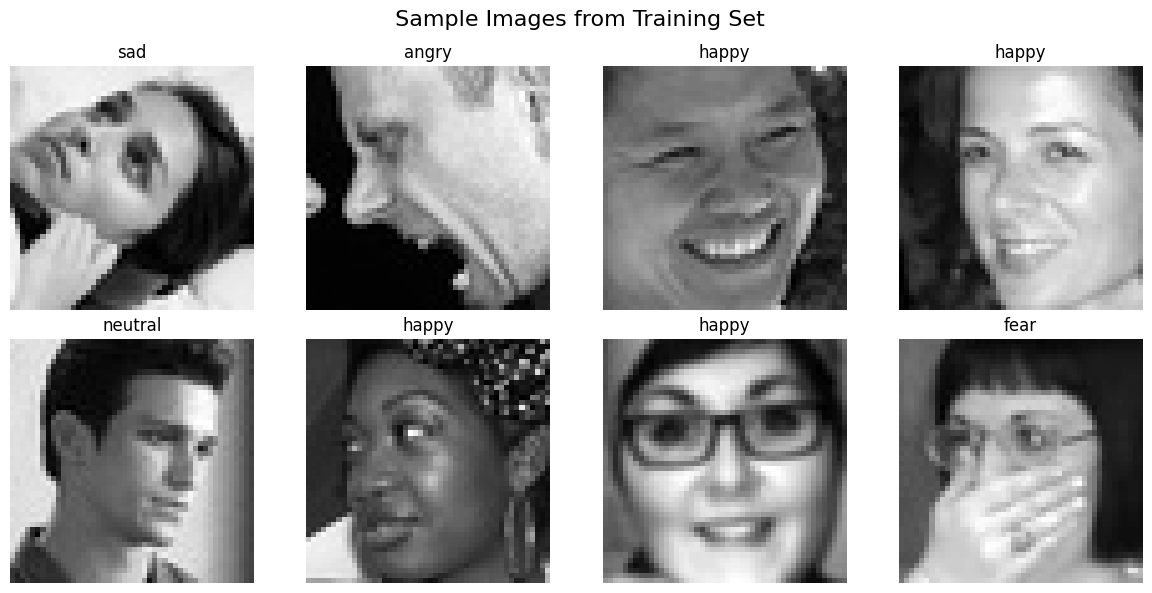

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(train_generator)

# Display a few images from the batch
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].reshape(48, 48), cmap="gray")
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.suptitle(" Sample Images from Training Set", fontsize=16)
plt.tight_layout()
plt.show()


**Model Architecture Design**

In [16]:
# Define the CNN model
model = Sequential()

# Add the first convolutional layer with max-pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))

# Add the second convolutional layer with max-pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Add the third convolutional layer with max-pooling
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the data before passing to fully connected layers
model.add(Flatten())

# Fully connected (dense) layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout to prevent overfitting
model.add(Dense(7, activation='softmax'))  # 7 emotions for classification

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to visualize the architecture
print(" Model Architecture:")
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,145,351 (4.37 MB)

 Trainable params: 1,145,351 (4.37 MB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

In [17]:
# Define callbacks to save the best model and stop early if validation accuracy doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('emotion_recognition_best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Print the training results
print("Training Complete")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2590 - loss: 1.8016

358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.2592 - loss: 1.8012 - val_accuracy: 0.4038 - val_loss: 1.5359
Epoch 2/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3594 - loss: 1.4692

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3594 - loss: 1.4692 - val_accuracy: 0.4077 - val_loss: 1.5336
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4176 - loss: 1.5012

358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.4177 - loss: 1.5011 - val_accuracy: 0.4821 - val_loss: 1.3709
Epoch 4/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4688 - loss: 1.4456 - val_accuracy: 0.4798 - val_loss: 1.3717
Epoch 5/50
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4941 - loss: 1.3386

358/358 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.4941 - loss: 1.3385 - val_accuracy: 0.5090 - val_loss: 1.2962
Epoch 6/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5938 - loss: 1.2080 - val_accuracy: 0.5051 - val_loss: 1.3056
Epoch 7/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5251 - loss: 1.2519

358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5251 - loss: 1.2519 - val_accuracy: 0.5381 - val_loss: 1.2318
Epoch 8/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4688 - loss: 1.1932 - val_accuracy: 0.5330 - val_loss: 1.2337
Epoch 9/50
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5484 - loss: 1.1794

358/358 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5484 - loss: 1.1793 - val_accuracy: 0.5564 - val_loss: 1.1950
Epoch 10/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5781 - loss: 1.1592 - val_accuracy: 0.5546 - val_loss: 1.1962
Epoch 11/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5804 - loss: 1.1063

358/358 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5804 - loss: 1.1063 - val_accuracy: 0.5514 - val_loss: 1.1829
Epoch 12/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5000 - loss: 1.2264 - val_accuracy: 0.5537 - val_loss: 1.1863
Epoch 13/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6075 - loss: 1.0378

358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6075 - loss: 1.0379 - val_accuracy: 0.5488 - val_loss: 1.1740
Epoch 14/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6250 - loss: 1.0930

358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6250 - loss: 1.0930 - val_accuracy: 0.5493 - val_loss: 1.1689
Epoch 15/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6335 - loss: 0.9832

358/358 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6335 - loss: 0.9832 - val_accuracy: 0.5699 - val_loss: 1.1520
Epoch 16/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5781 - loss: 1.1888

358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5781 - loss: 1.1888 - val_accuracy: 0.5716 - val_loss: 1.1505
Epoch 17/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6610 - loss: 0.9110 - val_accuracy: 0.5604 - val_loss: 1.2038
Epoch 18/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6562 - loss: 0.8755 - val_accuracy: 0.5599 - val_loss: 1.2125
Epoch 19/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6825 - loss: 0.8595 - val_accuracy: 0.5690 - val_loss: 1.2203
Epoch 20/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7188 - loss: 0.7025 - val_accuracy: 0.5715 - val_loss: 1.2079
Epoch 21/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.7092 - loss: 0.7897 - val_accuracy: 0.5718 - val_loss: 1.2293
Training Complete


**Evaluate the Model on Test Data**

In [19]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=1)

print(f"Test Loss: {test_loss}")
print(f" Test Accuracy: {test_acc * 100:.2f}%")


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5340 - loss: 1.2233
Test Loss: 1.158074140548706
 Test Accuracy: 56.25%


**Plot Training and Validation Accuracy and Loss**

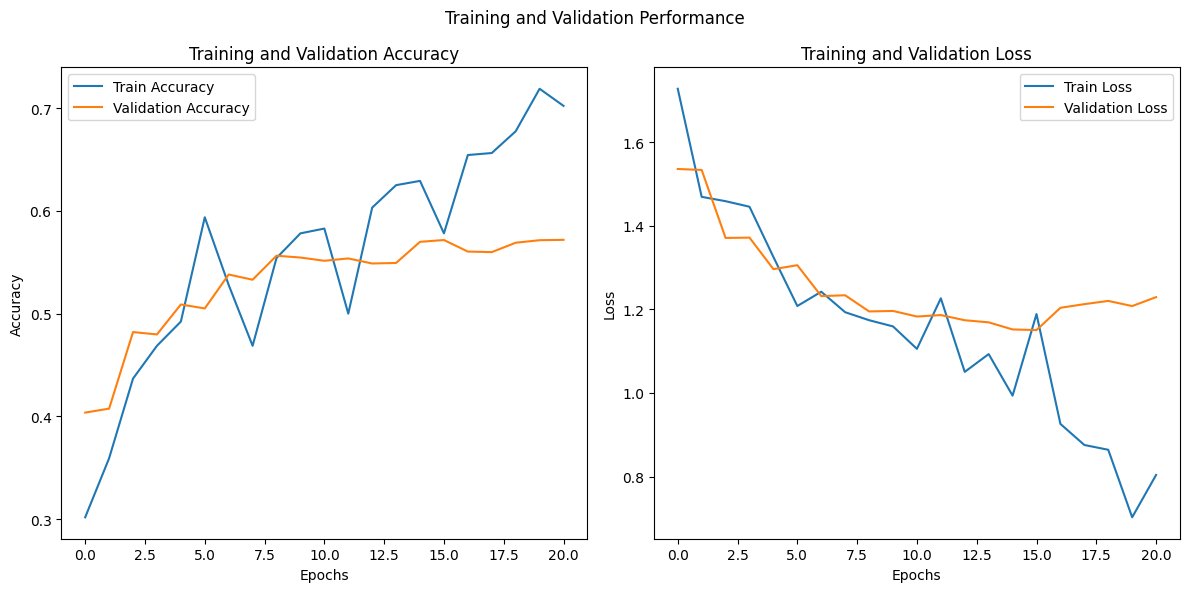

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Training and Validation Performance')
plt.tight_layout()
plt.show()


**Generate Classification Report & Confusion Matrix**

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step

 Classification Report:

              precision    recall  f1-score   support

       angry       0.45      0.53      0.48       958
     disgust       0.58      0.26      0.36       111
        fear       0.37      0.31      0.34      1024
       happy       0.75      0.81      0.78      1774
     neutral       0.51      0.57      0.54      1233
         sad       0.45      0.38      0.41      1247
    surprise       0.74      0.69      0.72       831

    accuracy                           0.56      7178
   macro avg       0.55      0.51      0.52      7178
weighted avg       0.56      0.56      0.56      7178



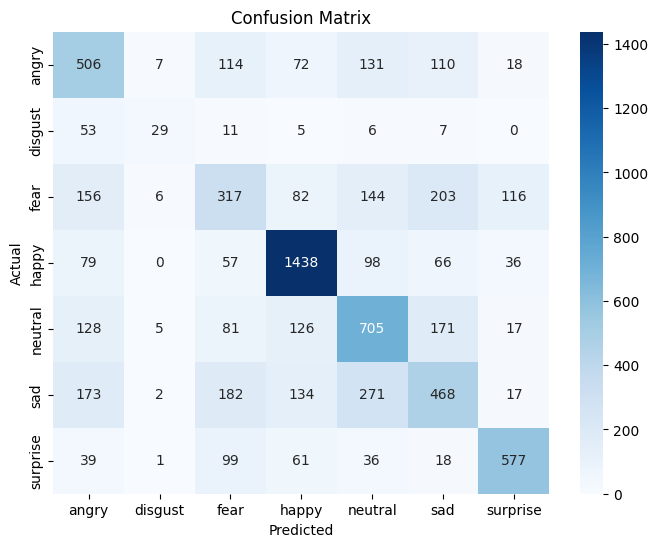

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Step 1: Get true labels and predicted labels
test_generator.reset()
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

# Step 2: Class labels
class_labels = list(test_generator.class_indices.keys())

# Step 3: Classification Report
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Step 4: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Build and Train with MobileNetV2**

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Paths
train_dir = '/content/train'
test_dir = '/content/test'

# Image dimensions (correct size for MobileNetV2)
img_size = (224, 224)

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze layers

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)

# Train model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)

# Save model
model.save("mobilenet_model.keras")

# Evaluate
loss, accuracy = model.evaluate(validation_generator)
print("Validation Accuracy:", accuracy)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 376s 407ms/step - accuracy: 0.2608 - loss: 2.0327 - val_accuracy: 0.3792 - val_loss: 1.5810 - learning_rate: 0.0010
Epoch 2/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 353s 393ms/step - accuracy: 0.3304 - loss: 1.7146 - val_accuracy: 0.3858 - val_loss: 1.5753 - learning_rate: 0.0010
Epoch 3/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 361s 402ms/step - accuracy: 0.3454 - loss: 1.6900 - val_accuracy: 0.3943 - val_loss: 1.5520 - learning_rate: 0.0010
Epoch 4/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 355s 395ms/step - accuracy: 0.3474 - loss: 1.6842 - val_accuracy: 0.3989 - val_loss: 1.5430 - learning_rate: 0.0010
Epoch 5/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 355s 395ms/step - accuracy: 0.3498 - loss: 1.6708 - val_accuracy: 0.3729 - val_loss: 1.5784 - learning_rate: 0.0010
Epoch 6/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.3540 - loss: 1.6809
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
898/898 ━━━━━━━━━━━━━━━━━━━━ 359s 400ms/step - accuracy:

**Fine tuning**

In [25]:
# Unfreeze last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 382s 412ms/step - accuracy: 0.3171 - loss: 1.8548 - val_accuracy: 0.4032 - val_loss: 1.5493 - learning_rate: 1.0000e-05
Epoch 2/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 362s 403ms/step - accuracy: 0.3610 - loss: 1.6390 - val_accuracy: 0.4209 - val_loss: 1.5198 - learning_rate: 1.0000e-05
Epoch 3/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 360s 401ms/step - accuracy: 0.3762 - loss: 1.5996 - val_accuracy: 0.4214 - val_loss: 1.5035 - learning_rate: 1.0000e-05
Epoch 4/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 361s 402ms/step - accuracy: 0.3865 - loss: 1.5753 - val_accuracy: 0.4372 - val_loss: 1.4694 - learning_rate: 1.0000e-05
Epoch 5/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 358s 399ms/step - accuracy: 0.3954 - loss: 1.5536 - val_accuracy: 0.4383 - val_loss: 1.4571 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.


**Plot Accuracy and Loss Curves**

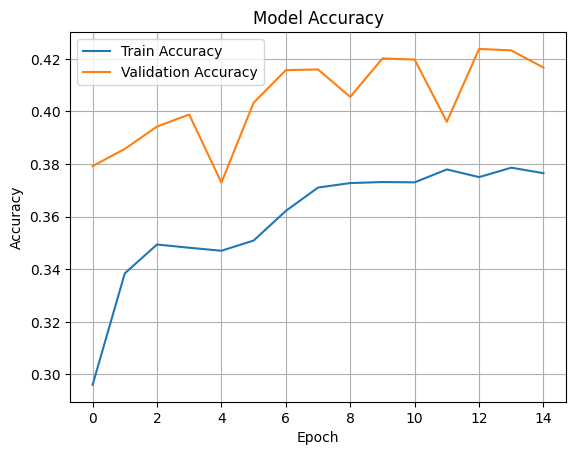

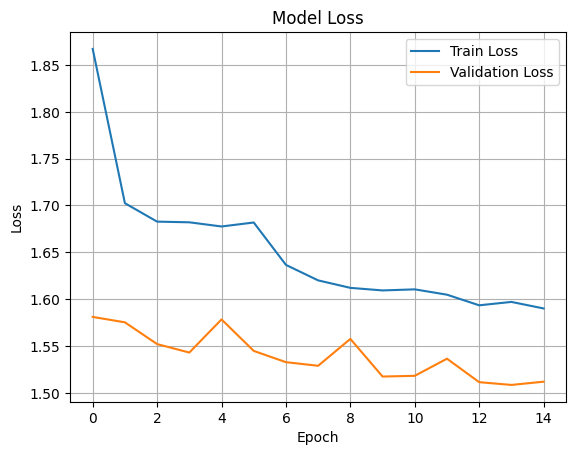

In [26]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


**Generate Confusion Matrix**

225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step


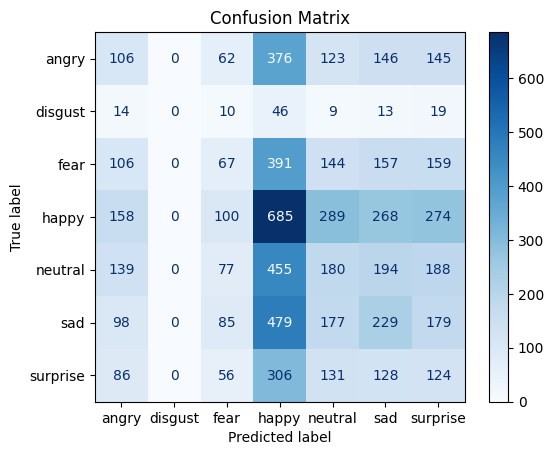

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on validation/test data
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


**Classification Report**

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))


              precision    recall  f1-score   support

       angry       0.15      0.11      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.07      0.09      1024
       happy       0.25      0.39      0.30      1774
     neutral       0.17      0.15      0.16      1233
         sad       0.20      0.18      0.19      1247
    surprise       0.11      0.15      0.13       831

    accuracy                           0.19      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.19      0.18      7178



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Testing**

In [36]:
!pip install tensorflow opencv-python-headless


In [37]:
from google.colab import files
uploaded = files.upload()


Saving mobilenet_model.keras to mobilenet_model (1).keras


In [38]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from IPython.display import Image
import cv2
import numpy as np
import PIL.Image
import io

def capture_image():
    # JS to take image from webcam
    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video stream
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg');
    }
    takePhoto();
    ''')
    display(js)

    data = eval_js("takePhoto()")
    binary = b64decode(data.split(',')[1])
    img = PIL.Image.open(io.BytesIO(binary))
    return img


In [42]:
from base64 import b64decode
from tensorflow.keras.models import load_model

# Load model
model = load_model("mobilenet_model.keras")
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Capture image
image = capture_image()

# Preprocess image
img = image.resize((224, 224))
img = np.array(img).astype("float32") / 255.0
img = np.expand_dims(img, axis=0)

# Predict emotion
pred = model.predict(img)
emotion = emotion_labels[np.argmax(pred)]

print("Detected Emotion:", emotion)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Detected Emotion: neutral
